# Import

In [ ]:
from __future__ import division
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import random

# Initialize a NN

In [ ]:
class Model(nn.Module):

  def __init__(self):
    super(Model,self).__init__()
    self.conv = nn.Sequential(nn.Conv2d(1,3,2),
                              nn.ReLU(),
                              nn.Conv2d(3,3,2),
                              nn.ReLU())

  def forward(self,x):
    return self.conv(x)

M = Model()
A_0 = torch.tensor([[-1,-1,-1.],[-2.5,-2.5,-2.5]])
B_0 = torch.tensor([[1.],[1.]])

def ReLU(x):
  x[x<0] = 0
  return x

A_1 = torch.tensor([[3,3.]])
#A_1 = torch.tensor([[7,8.]])
B_1 = torch.tensor([[1.]])

def Forward(x,M):
  x = M(x).squeeze().view([1,-1])
  #print(x)
  x = ReLU(x.mm(A_0.T)+B_0.T)
  x = x.mm(A_1.T)+B_1.T
  return x

def Hidden_layer(x,M):
  x = M(x).squeeze().view([1,-1])
  #print(x)
  x = ReLU(x.mm(A_0.T)+B_0.T)
  return x

# Find critical points in one direction

## Find candidate points and sort

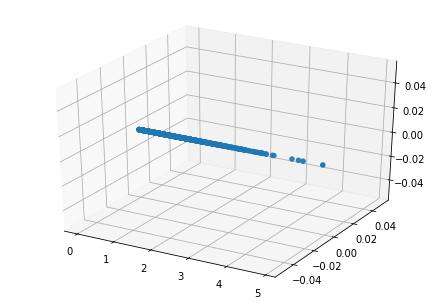

In [ ]:
def sort_cp(M,collection,direction,show=False):
  u = M(torch.tensor(collection[0]).view([1,1,3,3])).squeeze()
  v = M(torch.tensor(collection[1]).view([1,1,3,3])).squeeze()-u
  tmp = [[collection[0],0],[collection[1],1]]
  for each in collection[2:]:
    each_m = M(torch.tensor(each).view([1,1,3,3])).squeeze()
    tmp.append([each,((each_m-u)/v)[direction].item()])
  tmp = np.array(tmp)
  collection_sorted = (tmp[tmp[:,1].argsort()])[:,0]
  collection_sorted = torch.tensor([each.squeeze() for each in collection_sorted]).view([-1,1,3,3])
  collection_ob = M(collection_sorted).squeeze().detach()
  if show:
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(collection_ob[:,0], collection_ob[:,1], collection_ob[:,2])
  return collection_sorted,collection_ob

def find_cp(M,direction,show=False):
  direction = np.array(direction)
  collection = []
  for _ in range(10000):
    x = torch.randn(9)*10
    x = x.view([1,1,3,3])
    tmp = M(x).detach().squeeze().numpy()
    if tmp[np.where(direction==0)[0][0]]==0 and tmp[np.where(direction==0)[0][1]]==0 and tmp[np.where(direction!=0)[0][0]]!=0:
      collection.append(x.numpy())
  collection = np.array(collection)
  collection,collection_ob = sort_cp(M,collection,np.where(direction!=0)[0][0],show)
  return collection,collection_ob

collection,collection_ob = find_cp(M,[1,0,0],True)

## Draw the curve of gradient and smooth

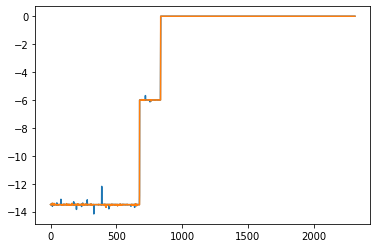

In [ ]:
def get_gradient_blackbox(collection,collection_ob,I):
  delta = np.linalg.norm(collection_ob[I+1]-collection_ob[I])
  y_right = Forward(collection[I+1].clone().view([-1,1,3,3]),M)
  y_left = Forward(collection[I].clone().view([-1,1,3,3]),M)
  return ((y_right-y_left)/delta).item()

def get_gradient_linspace(collection,collection_ob,show=False):
  gradient = []
  for i in range(1,len(collection)-1):
    gradient.append(get_gradient_blackbox(collection,collection_ob,i))
  if show:
    plt.plot(gradient)
  for i in range(len(gradient)-2):
    if abs(gradient[i+1]-gradient[i])>0.1 and abs(gradient[i+2]-gradient[i+1])>0.1:
      gradient[i+1] = gradient[i]
  if show:
    plt.plot(gradient)
  return gradient

gradient = get_gradient_linspace(collection,collection_ob,True)

## Find critical points

{677: [676, 677], 837: [836, 837]}
tensor([0.3988, 0.0000, 0.0000])
tensor([0.4998, 0.0000, 0.0000])


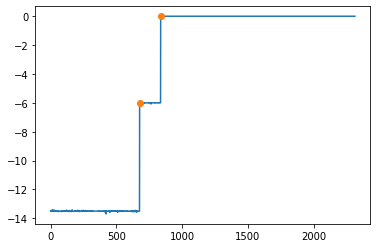

In [ ]:
def get_singular_point_index(g):
  gradient_singularity_idx = []
  for i in range(1,len(g)-1):
      if abs(g[i-1]-g[i])>0.5 or abs(g[i]-g[i+1])>0.5:
        gradient_singularity_idx.append(i)
  return gradient_singularity_idx

def get_critical_point(g,show=False):
  critical_point = {}
  gradient_singularity_idx = get_singular_point_index(g)
  res = []
  tmp = []
  jmp = True
  for each in gradient_singularity_idx:
    if jmp:
      tmp.append(each)
      jmp = False
      continue
    if each-tmp[-1] == 1:
      tmp.append(each)
    else:
      res.append(tmp)
      critical_point[tmp[round(len(tmp)/2)]] = [tmp[0],tmp[-1]]
      tmp = [each]
  if tmp:
    res.append(tmp)
    critical_point[tmp[round(len(tmp)/2)]] = [tmp[0],tmp[-1]]
  if show:
    print(critical_point)
    plt.plot(g)
    plt.plot(list(critical_point.keys()),[g[list(critical_point.keys())[0]],g[list(critical_point.keys())[1]]],'o')
    print(collection_ob[list(critical_point.keys())[0]])
    print(collection_ob[list(critical_point.keys())[1]])
  return critical_point

critical_point = get_critical_point(gradient,True)

# Recover A_0 in one direction

In [ ]:
def gradient_delta(critical_point,collection,collection_ob):
  res = []
  for each in critical_point:
    left_cp = each-2
    right_cp = each+2
    left_gradient = get_gradient_blackbox(collection,collection_ob,left_cp)
    right_gradient = get_gradient_blackbox(collection,collection_ob,right_cp)
    res.append(right_gradient-left_gradient)
  return res

gd = []
gd.append(gradient_delta(critical_point,collection,collection_ob))
print(gd)

[[19.999893188476562, 14.000103950500488]]


# Recover A_0 in all diretions

In [ ]:
gd = []
for each in [[1,0,0],[0,1,0],[0,0,1]]:
  collection,collection_ob = find_cp(M,each)
  gradient = get_gradient_linspace(collection,collection_ob)
  critical_point = get_critical_point(gradient)
  gd.append(gradient_delta(critical_point,collection,collection_ob))
gd = np.array(gd)

In [ ]:
A_0_recovered = -torch.ones([2,3])
A_0_recovered[1,0] = -2.5
for i,each in enumerate(gd.T):
  base = each[0]
  A_0_recovered[i,1] = each[1]/each[0]*A_0_recovered[i,0]
  A_0_recovered[i,2] = each[2]/each[0]*A_0_recovered[i,0]
print(A_0_recovered)
print(A_0)

tensor([[-1.0000, -1.0000, -1.0000],
        [-2.5001, -2.5012, -2.4983]])
tensor([[-1.0000, -1.0000, -1.0000],
        [-2.5000, -2.5000, -2.5000]])


# Recover B_0

In [ ]:
B_0_recovered = torch.zeros([1,2])
for i,each in enumerate(critical_point):
  x = collection[each].clone().view([1,1,3,3])
  x = M(x).squeeze().view([1,-1])
  x = x.mm(A_0_recovered.T)
  B_0_recovered[0,i] = -x[0,i]
print(B_0_recovered.T)
print(B_0)

tensor([[1.0021],
        [1.0085]], grad_fn=<PermuteBackward>)
tensor([[1.],
        [1.]])


# Recover A_1 & B_1

In [ ]:
tmp = []
for _ in range(300):
  x = torch.randn(9)*10
  x = x.view([1,1,3,3])
  x_p = M(x).squeeze().view([1,-1])
  x_p = ReLU(x_p.mm(A_0_recovered.T)+B_0_recovered).squeeze().detach().numpy()
  if x_p[0]!=0 and x_p[1]!=0:
    tmp.append(x)
    if len(tmp)==3:
      print('Stand by')
      break

Stand by


In [ ]:
A = []
B = []
for i in range(3):
  x = M(tmp[i]).squeeze().view([1,-1])
  A.append(np.append(ReLU(x.mm(A_0_recovered.T)+B_0_recovered).squeeze().detach().numpy(),[1.]))
  B.append(Forward(tmp[i],M).squeeze().detach().numpy())
print(A)
print(B)

[array([0.68988866, 0.22823989, 1.        ]), array([0.66011071, 0.15411335, 1.        ]), array([1.00209641, 1.00848818, 1.        ])]
[array(3.72189, dtype=float32), array(3.409306, dtype=float32), array(7., dtype=float32)]


In [ ]:
abs(A[0][0]*3+A[0][1]*3+1-B[0])

0.032819271087646484

In [ ]:
abs(A[1][0]*3+A[1][1]*3+1-B[1])

0.031827449798583984

In [ ]:
abs(A[2][0]*3+A[2][1]*3+1-B[2])

0.032481253147125244